# 42186 - Model-based Machine Learning Project
## Group 12

------

### This notebook seek to analyse and model outpatient activity and visit duration at Rigshospitalet.


First the following packages, scripts and data has to be loaded

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
from sklearn.metrics import mean_squared_error

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam


# RUN THE SCRIPT Preprocess_data.py ONE TIME
# load data CaseRigshospitalet_summed.parquet
df = pd.read_parquet('data/CaseRigshospitalet_summed.parquet')

/Users/signeolsen/opt/anaconda3/envs/MachineLearning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook will take you thourgh some models, which seek to predict the contact duration in hours. 

First we will try out with a simple probabilistic graphical model, namely the Heteroscedatic regression model. Thereafter wee seek to expand the model by including patient profile and create a Mixture model...

Finale wee want to compare the findings to a Multiple-channel latent Dirichlet allocation.

### Content
* Visualization of the data
* Heteroscedatic regression model using diagnostic
* Mixture model using patient profile
* Multiple-channel latent Dirichlet allocation

## Visualization of the data

First we will have a look at the data that we are working with, run the following code and have a look at some of the attributes (it is in danish).


In [3]:
print(df.head())

  Patient ID Aktionsdiagnosekode  totalDiagnoseKontaktVarighed  \
0                          DH469                          0.17   
1                          DZ340                          5.11   
2                          DZ713                          0.02   
3                        DZ768E4                          3.44   
4       Z100               DM059                          1.65   

   antalKontakter  antalDiagnoser      alder  gender civilStand  \
0               1               4       29.0                      
1               9               4       33.0                      
2               1               4       33.0                      
3               6               4  26.666667                      
4               2               1       51.0  Kvinde       Gift   

   distanceToHospitalKM                                          embedding  
0           7940.438584  [0.0707629, -0.13380641, 0.40466323, -0.157186...  
1           7940.438584  [0.024896344, -0.4907

## Simple PGM using diagnostic

The dataset have an attribute called 'Action diagnostic code', which we have made an Bert embedding on.

The Heteroscedatic regression model take as input a BERT embedding of the observed variable diagnosis description, $\bm{x}=BERT(diagnosis)$, where $x \in \mathbb{R}^K$. 

The Generative Process
1) Draw $\beta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

2) Draw $\eta_k \sim \mathcal{N}(0,1)$, for $k \in \{1,2,\dots, K\}$

3) For each patient, $p$, in $P$

    a) Draw $v_p \sim \text{LogNormal}(\beta^T\mathbb{x}_p, \eta^T \mathbb{x}_p)$

Notice how LogNormal is used, as it only maps to the posetive side of the x-axis.

In [20]:
    from sklearn.model_selection import train_test_split

    total_samples = 10000
    # Convert list of lists to a 2D NumPy array
    embedding_length = len(df["embedding"].iloc[0])  # Assuming all embeddings should have the same length
    df["embedding"] = df["embedding"].apply(lambda x: x if len(x) == embedding_length else [0.0] * embedding_length)
    embeddings = np.array(df["embedding"].tolist(), dtype=np.float32)
    embedding_tensor = torch.from_numpy(embeddings)

    # Make vector for each row with alder, gender (one hot encoding), civilStand (one hot encoding), distanceToHospitalKM
    demographic_data = torch.from_numpy(make_demographic_features(df))

    # 1. Convert target to numpy
    y_time = torch.from_numpy(df['totalDiagnoseKontaktVarighed'].values.astype(np.float32))
    y_count = torch.from_numpy(df["antalKontakter"].values.astype(np.int16))

    # 2. Randomly select indices
    all_indices = np.arange(len(embedding_tensor))

    selected_indices = np.random.choice(all_indices, size=total_samples, replace=False)
    df_subset = df.iloc[selected_indices]

    # Select based on patient ID, can't have same patient in train and test
    unique_patient_ids = df_subset['Patient ID'].unique()

    train_patient_ids, test_patient_ids = train_test_split(
        unique_patient_ids, test_size=0.2, random_state=42
    )
    train_mask = df_subset['Patient ID'].isin(train_patient_ids)
    test_mask = df_subset['Patient ID'].isin(test_patient_ids)

    # Use the mask to filter rows
    x_emb_train = embedding_tensor[selected_indices][train_mask.values]
    d_demo_train = demographic_data[selected_indices][train_mask.values]
    v_time_train = y_time[selected_indices][train_mask.values]
    a_count_train = y_count[selected_indices][train_mask.values]

    x_emb_test = embedding_tensor[selected_indices][test_mask.values]
    d_demo_test = demographic_data[selected_indices][test_mask.values]
    v_time_test = y_time[selected_indices][test_mask.values]
    a_count_test = y_count[selected_indices][test_mask.values]


Demographic columns: ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt', 'civilStand_Død', 'civilStand_Enke/enkemand', 'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Længst levende partner', 'civilStand_Opbrudt partnerskab', 'civilStand_Registreret partnerskab', 'civilStand_Ugift']


In [21]:
X_train = x_emb_train
y_train = v_time_train
X_test = x_emb_test
y_test = v_time_test

In [204]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam
import pyro.poutine as poutine

# ==== Set random seed for reproducibility ====
pyro.set_rng_seed(0)

# ==== Simulated Data ====
P, D = X_train.shape
true_beta = torch.randn(D)
true_eta = torch.randn(D)

X = X_train
y = y_train

# ==== Models ====
def log_normal(data, targets=None):
    P, D = data.shape

    # Prior over beta
    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.tensor(1.0)  # Fixed scalar standard deviation
        pyro.sample("obs", dist.LogNormal(loc, scale), obs=targets)


def heteroscedastic_regression(data, targets=None):
    P, D = data.shape

    # Prior on beta and eta
    beta = pyro.sample("beta", dist.Normal(0., 0.1).expand([D]).to_event(1))
    eta = pyro.sample("eta", dist.Normal(0., 0.1).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.nn.functional.softplus(data @ eta) + 1e-3
        pyro.sample("v", dist.LogNormal(loc, scale), obs=targets)

# ==== Guide ====
guide = AutoNormal(heteroscedastic_regression)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(heteroscedastic_regression, guide, optimizer, loss=elbo)

n_steps = 3000
for step in range(n_steps):
    loss = svi.step(X, y)
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimates ====
posterior = guide(X)
beta_mean_d = posterior["beta"]
eta_mean_d = posterior["eta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean_d[:5])
print("Posterior mean of eta (first 5 dims):", eta_mean_d[:5])


[0] ELBO: 1913701.12
[500] ELBO: 25879.87
[1000] ELBO: 26845.31
[1500] ELBO: 24743.64
[2000] ELBO: 25807.19
[2500] ELBO: 39116.17

Posterior mean of beta (first 5 dims): tensor([ 0.0156,  0.0405, -0.0512,  0.0965, -0.0442], grad_fn=<SliceBackward0>)
Posterior mean of eta (first 5 dims): tensor([ 0.1711, -0.4615,  0.0644, -0.3561, -0.2682], grad_fn=<SliceBackward0>)


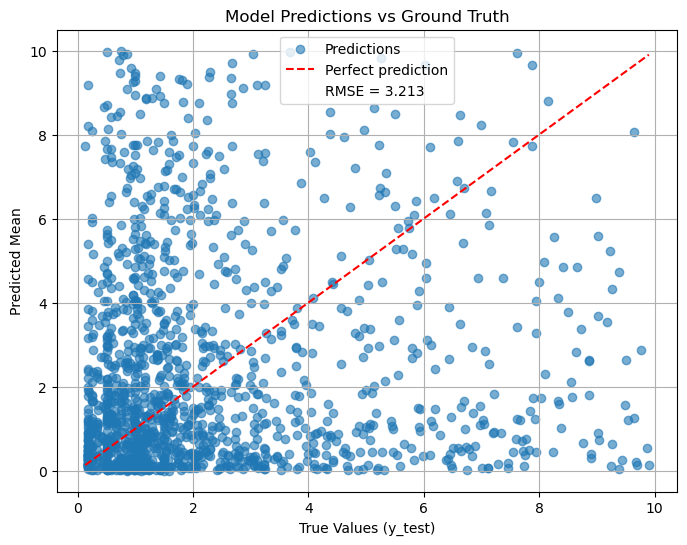

In [253]:
y_pred_log = dist.LogNormal(X_test @ beta_mean_d, torch.nn.functional.softplus(X_test @ eta_mean_d) + 1e-3).sample()

# Convert to numpy for easy filtering
y_pred_np = y_pred_log.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Define a max value threshold (e.g., 1e6) to clip out extreme values
threshold = 1e1

# Create a valid mask
mask = np.isfinite(y_pred_np) & (y_pred_np < threshold) & (y_test_np < threshold)

# Apply the mask
y_pred_clean = y_pred_np[mask]
y_test_clean = y_test_np[mask]


# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_clean, y_pred_clean, alpha=0.6, label="Predictions")
plt.plot([y_test_clean.min(), y_test_clean.max()],
         [y_test_clean.min(), y_test_clean.max()],
         'r--', label="Perfect prediction")

# Add dummy plot for RMSE
plt.plot([], [], ' ', label=f"RMSE = {rmse:.3f}")

plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Mean")
plt.title("Model Predictions vs Ground Truth")
plt.legend()
plt.grid(True)
plt.show()


The input to the model is a BERT embedding of the observed variable diagnosis description, $\bm{x}=BERT(diagnosis)$, where $x \in \mathbb{R}^K$.

## PGM using also patient profile

In [34]:
X_train = torch.cat((x_emb_train, d_demo_train), dim=1)
X_test = torch.cat((x_emb_test, d_demo_test), dim=1)

In [35]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam
import pyro.poutine as poutine

# ==== Set random seed for reproducibility ====
pyro.set_rng_seed(0)

# ==== Simulated Data ====
P, D = X_train.shape
true_beta = torch.randn(D)
true_eta = torch.randn(D)

X = X_train
y = v_time_train

# ==== Models ====
def log_normal(data, targets=None):
    P, D = data.shape

    # Prior over beta
    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.tensor(1.0)  # Fixed scalar standard deviation
        pyro.sample("obs", dist.LogNormal(loc, scale), obs=targets)


def heteroscedastic_regression(data, targets=None):
    P, D = data.shape

    # Prior on beta and eta
    beta = pyro.sample("beta", dist.Normal(0., 0.1).expand([D]).to_event(1))
    eta = pyro.sample("eta", dist.Normal(0., 0.1).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.nn.functional.softplus(data @ eta) + 1e-3

        pyro.sample("v", dist.LogNormal(loc, scale), obs=targets)


# ==== Guide ====
guide = AutoNormal(heteroscedastic_regression)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(heteroscedastic_regression, guide, optimizer, loss=elbo)

n_steps = 3000
for step in range(n_steps):
    loss = svi.step(X, y)
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimates ====
posterior = guide(X)
beta_mean_PP = posterior["beta"]
eta_mean_PP = posterior["eta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean_PP[:5])
print("Posterior mean of eta (first 5 dims):", eta_mean_PP[:5])


[0] ELBO: 28520289194187.23
[500] ELBO: 33943.68
[1000] ELBO: 31303.04
[1500] ELBO: 35721.46
[2000] ELBO: 34958.58
[2500] ELBO: 33923.42

Posterior mean of beta (first 5 dims): tensor([-0.0630,  0.0579,  0.0923,  0.0046,  0.0699], grad_fn=<SliceBackward0>)
Posterior mean of eta (first 5 dims): tensor([ 0.6094, -0.5020, -0.0544, -0.6598, -0.1695], grad_fn=<SliceBackward0>)


In [50]:
import numpy as np

# Get beta as numpy
beta_np = beta_mean_PP.cpu().detach().numpy()

# Get indices of top 2 absolute beta values
top2_indices = np.argsort(np.abs(beta_np))[-2:][::-1]  # descending order
top2_betas = beta_np[top2_indices]

print("Top 2 influential beta indices and values:")
for i, idx in enumerate(top2_indices):
    print(f"{i+1}: Index = {idx}, Beta = {top2_betas[i]:.4f}")

# Assume this:
num_emb_features = x_emb_train.shape[1]
demo_columns = df.columns.tolist()

feature_names = [f"emb_{i}" for i in range(num_emb_features)] + demo_columns

# Print out feature names and their corresponding betas
for i, idx in enumerate(top2_indices):
    feature_name = feature_names[idx]
    beta_value = top2_betas[i]
    print(f"Top {i+1} Feature: {feature_name} (Index {idx}), Beta = {beta_value:.4f}")



Top 2 influential beta indices and values:
1: Index = 570, Beta = -0.3028
2: Index = 486, Beta = -0.2440
Top 1 Feature: emb_570 (Index 570), Beta = -0.3028
Top 2 Feature: emb_486 (Index 486), Beta = -0.2440


In [51]:
# This gives you the values of that embedding dimension across all samples
top_beta_idx = np.argmax(np.abs(beta_np))

top_emb_values = x_emb_train[:, top_beta_idx]
top_emb_values

tensor([-0.2271,  0.4496,  0.1455,  ..., -0.0338, -0.3202, -0.2997])

In [52]:
# Index of row with highest value in the top dimension

max_idx = embedding_dim_values.idxmax()

# Get the corresponding code
most_associated_code = df.loc[max_idx, 'Aktionsdiagnosekode']
print("Most associated Aktionsdiagnosekode:", most_associated_code)


Most associated Aktionsdiagnosekode: DQ371


In [33]:
import numpy as np
import torch

beta_np = beta_mean_PP.cpu().detach().numpy()

# Find the index of the most influential beta (absolute value)
top_beta_idx = np.argmax(np.abs(beta_np))

# Reconstruct the original training subset DataFrame
df_train_subset = df.iloc[selected_indices].reset_index(drop=True)
df_train = df_train_subset[train_mask.values].reset_index(drop=True)

# Get the top embedding values at that beta dimension
top_emb_values = df_train['embedding'].apply(lambda emb: emb[top_beta_idx])

# Find the index of the highest value in that embedding dimension
max_idx = top_emb_values.idxmax()

# Get the corresponding Aktionsdiagnosekode
most_influential_code = df_train.loc[max_idx, 'Aktionsdiagnosekode']

print("Most influential beta index:", top_beta_idx)
print("Aktionsdiagnosekode corresponding to highest value in that dimension:", most_influential_code)


Most influential beta index: 570
Aktionsdiagnosekode corresponding to highest value in that dimension: DQ371


In [302]:
import numpy as np

# Ensure beta is on CPU if it’s a torch tensor
beta_np = beta_mean_PP.cpu().numpy()

# Find the most influential dimension
top_beta_idx = np.argmax(np.abs(beta_np))

# Get the value at that dimension for every embedding in the dataframe
top_emb_values = df['embedding'].apply(lambda emb: emb[top_beta_idx])

# Find the index of the maximum value in that dimension
max_idx = top_emb_values.idxmax()

# Get the corresponding Aktionsdiagnosekode
most_influential_code = df.loc[max_idx, 'Aktionsdiagnosekode']

print("Most influential dimension:", top_beta_idx)
print("Aktionsdiagnosekode associated with highest value in that dimension:", most_influential_code)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

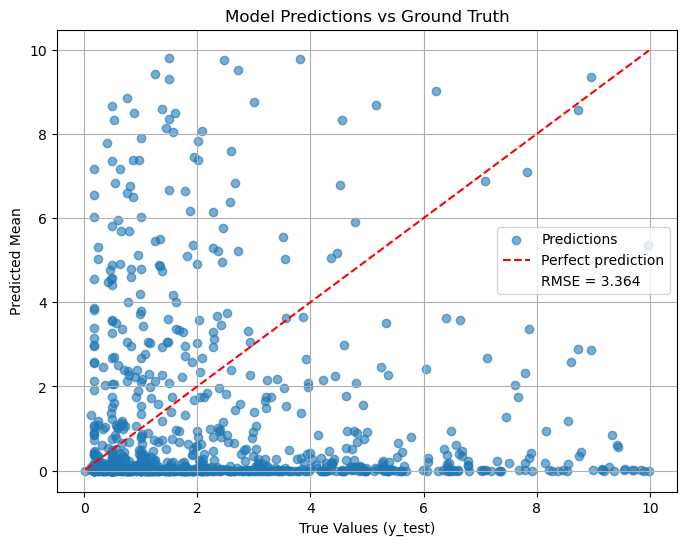

In [40]:
y_pred_log = dist.LogNormal(X_test @ beta_mean_PP, torch.nn.functional.softplus(X_test @ eta_mean_PP) + 1e-3).sample()

# Convert to numpy for easy filtering
y_pred_np = y_pred_log.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Define a max value threshold (e.g., 1e6) to clip out extreme values
threshold = 1e1

# Create a valid mask
mask = np.isfinite(y_pred_np) & (y_pred_np < threshold) & (y_test_np < threshold)

# Apply the mask
y_pred_clean = y_pred_np[mask]
y_test_clean = y_test_np[mask]


# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_clean, y_pred_clean, alpha=0.6, label="Predictions")
plt.plot([y_test_clean.min(), y_test_clean.max()],
         [y_test_clean.min(), y_test_clean.max()],
         'r--', label="Perfect prediction")

# Add dummy plot for RMSE
plt.plot([], [], ' ', label=f"RMSE = {rmse:.3f}")

plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Mean")
plt.title("Model Predictions vs Ground Truth")
plt.legend()
plt.grid(True)
plt.show()

## Full model with no corr

In [41]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam
import pyro.poutine as poutine

# ==== Set random seed for reproducibility ====
pyro.set_rng_seed(0)

# ==== Simulated Data ====
P, D = X_train.shape
true_beta = torch.randn(D)
true_eta = torch.randn(D)

X = X_train
y = v_time_train

# ==== Models ====
def log_normal(data, targets=None):
    P, D = data.shape

    # Prior over beta
    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.tensor(1.0)  # Fixed scalar standard deviation
        pyro.sample("obs", dist.LogNormal(loc, scale), obs=targets)


def heteroscedastic_regression(data, targets=None):
    P, D = data.shape

    # Prior on beta and eta
    beta = pyro.sample("beta", dist.Normal(0., 0.1).expand([D]).to_event(1))
    eta = pyro.sample("eta", dist.Normal(0., 0.1).expand([D]).to_event(1))

    with pyro.plate("data", P):
        loc = data @ beta
        scale = torch.nn.functional.softplus(data @ eta) + 1e-3

        pyro.sample("v", dist.LogNormal(loc, scale), obs=targets)


# ==== Guide ====
guide = AutoNormal(log_normal)

# ==== Optimizer ====
pyro.clear_param_store()
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# ==== Inference ====
elbo = Trace_ELBO(num_particles=3)
svi = SVI(log_normal, guide, optimizer, loss=elbo)

n_steps = 3000
for step in range(n_steps):
    loss = svi.step(X, y)
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")

# ==== Posterior Mean Estimates ====
posterior = guide(X)
beta_mean_PP_I = posterior["beta"]
#eta_mean_PP_I = posterior["eta"]

print("\nPosterior mean of beta (first 5 dims):", beta_mean_PP_I[:5])
#print("Posterior mean of eta (first 5 dims):", eta_mean_PP_I[:5])


[0] ELBO: 27333292.12
[500] ELBO: 243896.63
[1000] ELBO: 28871.45
[1500] ELBO: 30503.69
[2000] ELBO: 23455.76
[2500] ELBO: 19925.38

Posterior mean of beta (first 5 dims): tensor([ 0.0410, -0.0575,  0.0078,  0.0807, -0.0401], grad_fn=<SliceBackward0>)


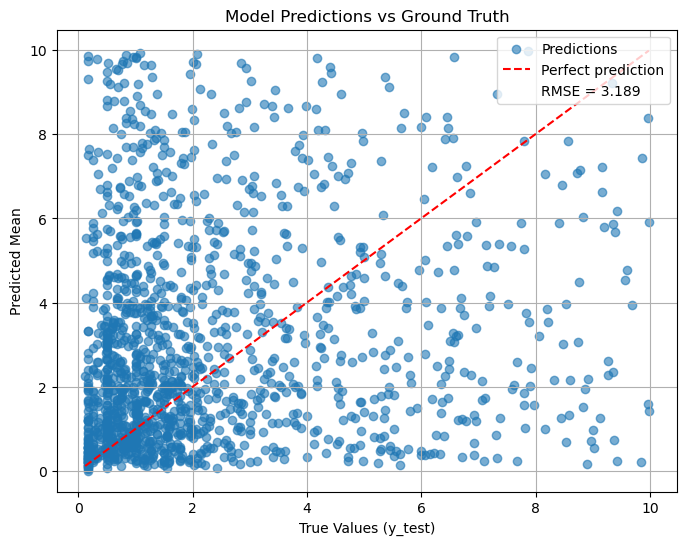

In [42]:
y_pred_log = dist.LogNormal(X_test @ beta_mean_PP_I, torch.tensor(1.0)).sample()

# Convert to numpy for easy filtering
y_pred_np = y_pred_log.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Define a max value threshold (e.g., 1e6) to clip out extreme values
threshold = 1e1

# Create a valid mask
mask = np.isfinite(y_pred_np) & (y_pred_np < threshold) & (y_test_np < threshold)

# Apply the mask
y_pred_clean = y_pred_np[mask]
y_test_clean = y_test_np[mask]


# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_clean, y_pred_clean, alpha=0.6, label="Predictions")
plt.plot([y_test_clean.min(), y_test_clean.max()],
         [y_test_clean.min(), y_test_clean.max()],
         'r--', label="Perfect prediction")

# Add dummy plot for RMSE
plt.plot([], [], ' ', label=f"RMSE = {rmse:.3f}")

plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Mean")
plt.title("Model Predictions vs Ground Truth")
plt.legend()
plt.grid(True)
plt.show()
